In [16]:
import warnings 
warnings.filterwarnings('ignore')
import time 
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
#from scipy.special import boxcox1p
from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor 
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
#from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from scipy.stats import spearmanr, pearsonr

import itertools
import xgboost as xgb
from sklearn.svm import SVR
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor

In [2]:
def get_score(model, X, y_true):
    y_pred = model.predict(X)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_precision_error(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

# Data gathering

In [4]:
data      = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/ubaar-competition/train.csv')
test_data = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/ubaar-competition/test.csv')

# Remove NANs
data      = data.dropna(axis = 0)

# Remove outliers
data.drop([28098])
THRESHOLD = 3.5e7
Aa = data[data.price > THRESHOLD]
data = data.drop(Aa.index.tolist())

specific_cols = ['distanceKM', 'taxiDurationMin', 'weight']
removed_indices = []
for col in specific_cols:
    df = data['price']/data[col]
    A = df[~df.isin([np.nan, np.inf, -np.inf])]
    B = (A - np.mean(A)) / np.std(A)
    V = B[B > 5]
    removed_indices.extend(V.index.tolist())
data = data.drop(set(removed_indices))

# Fill test NANs
test_data.loc[12577, 'distanceKM']      = 52
test_data.loc[12577, 'taxiDurationMin'] = 50
test_data.loc[13853, 'distanceKM']      = 500
test_data.loc[13853, 'taxiDurationMin'] = 380

all_data = pd.concat((data, test_data)) 
all_data['source']           = all_data['sourceLatitude']*all_data['sourceLongitude']
all_data['destination']      = all_data['destinationLatitude']*all_data['destinationLongitude']

ntrain = data.shape[0]
ntest  = test_data.shape[0]

categorical_vars = ['date', 'SourceState', 'destinationState', 'vehicleType', 'vehicleOption']

dummies_data = pd.get_dummies(all_data[categorical_vars])
all_data[dummies_data.columns] = dummies_data[dummies_data.columns]
all_data.drop(categorical_vars, axis=1, inplace=True)

train    = all_data[:ntrain]
test     = all_data[ntrain:]

#X = train.drop(['ID','price'],axis=1)
#y = train.price

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train.head()

# Initial models 

In [ ]:
GBoost_1 = GradientBoostingRegressor(n_estimators=15000, learning_rate=0.01,
                                     max_depth=10, max_features='sqrt',
                                     min_samples_leaf=15, min_samples_split=10, loss='huber')

GBoost_2 = GradientBoostingRegressor(n_estimators=15000, learning_rate=0.01,
                                  max_depth=10, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10, loss='huber')

xgb_1 = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                        learning_rate=0.01, max_depth=12, 
                        min_child_weight=1.7817, n_estimators=8000,
                        reg_alpha=0.9640, reg_lambda=0.8571,
                        subsample=1, silent=1, nthread = -1)

xgb_2 = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                        learning_rate=0.01, max_depth=12, 
                        min_child_weight=1.7817, n_estimators=8000,
                        reg_alpha=0.9640, reg_lambda=0.8571,
                        subsample=1, silent=1, nthread = -1)

lgb_1 = lgb.LGBMRegressor(objective='regression',num_leaves=25, #save_binary = True,  
                          learning_rate=0.01, n_estimators=60000,
                          max_bin = 150, bagging_fraction = 0.95,
                          bagging_freq = 4, feature_fraction = 0.8,
                          feature_fraction_seed=50, bagging_seed=20,
                          min_data_in_leaf = 11, min_sum_hessian_in_leaf = 11)

lgb_2 = lgb.LGBMRegressor(objective='regression',num_leaves=25, #save_binary = True,  
                          learning_rate=0.01, n_estimators=60000,
                          max_bin = 150, bagging_fraction = 0.95,
                          bagging_freq = 4, feature_fraction = 0.8,
                          feature_fraction_seed=50, bagging_seed=20,
                          min_data_in_leaf = 11, min_sum_hessian_in_leaf = 11)

In [ ]:
start_time = time.time()

train_11, train_12 = train_test_split(train, test_size=0.5)

GBoost_1.fit(train_11.drop(['ID','price'],axis=1), train_11.price)
GBoost_2.fit(train_12.drop(['ID','price'],axis=1), train_12.price)

train_11['y_gboost'] = GBoost_2.predict(train_11.drop(['ID','price'],axis=1))
train_12['y_gboost'] = GBoost_1.predict(train_12.drop(['ID','price'],axis=1))

train_1 = pd.concat([train_11, train_12]) 

train_21, train_22 = train_test_split(train_1, test_size=0.5)

xgb_1.fit(train_21.drop(['ID','price', 'y_gboost'],axis=1), train_21.price)
xgb_2.fit(train_22.drop(['ID','price', 'y_gboost'],axis=1), train_22.price)

train_21['y_xgb'] = xgb_2.predict(train_21.drop(['ID','price', 'y_gboost'],axis=1))
train_22['y_xgb'] = xgb_1.predict(train_22.drop(['ID','price', 'y_gboost'],axis=1))

train_2 = pd.concat([train_21, train_22])

train_31, train_32 = train_test_split(train_2, test_size=0.5)

lgb_1.fit(train_31.drop(['ID','price', 'y_gboost', 'y_xgb'],axis=1), train_31.price)
lgb_2.fit(train_32.drop(['ID','price', 'y_gboost', 'y_xgb'],axis=1), train_32.price)

train_31['y_lgb'] = lgb_2.predict(train_31.drop(['ID','price', 'y_gboost', 'y_xgb'],axis=1))
train_32['y_lgb'] = lgb_1.predict(train_32.drop(['ID','price', 'y_gboost', 'y_xgb'],axis=1))

train_3 = pd.concat([train_31, train_32])
train_3.to_pickle('dataFrames/train_OneHotEncoding_new_June14th.pkl')

print( '%.2f' % float((time.time() - start_time)/60 )  + ' mins')

In [ ]:
start_time = time.time()

train_41, train_42 = train_test_split(train_3, test_size=0.5)

avg_model_1 = AveragingModels(models = (xgb_1, lgb_1))
avg_model_2 = AveragingModels(models = (xgb_2, lgb_2))

avg_model_1.fit(train_41.drop(['ID','price', 'y_gboost', 'y_xgb', 'y_lgb'],axis=1), train_41.price)
avg_model_2.fit(train_42.drop(['ID','price', 'y_gboost', 'y_xgb', 'y_lgb'],axis=1), train_42.price)

train_41['y_avg_lgb_xgb'] = avg_model_2.predict(train_41.drop(['ID','price', 'y_gboost', 'y_xgb', 'y_lgb'],axis=1))
train_42['y_avg_lgb_xgb'] = avg_model_1.predict(train_42.drop(['ID','price', 'y_gboost', 'y_xgb', 'y_lgb'],axis=1))

train_4 = pd.concat([train_41, train_42])
train_4.to_pickle('dataFrames/train_OneHotEncoding_new_June14th.pkl')

print( '%.2f' % float((time.time() - start_time)/60 )  + ' mins')
# 45.20 mins

# Test dataset augmentation

In [ ]:
start_time = time.time()
GBoost = GradientBoostingRegressor(n_estimators=15000, learning_rate=0.01,
                                     max_depth=10, max_features='sqrt',
                                     min_samples_leaf=15, min_samples_split=10, loss='huber')

xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.01, max_depth=12, 
                             min_child_weight=1.7817, n_estimators=8000,
                             reg_alpha=0.9640, reg_lambda=0.8571,
                             subsample=1, silent=1, nthread = -1)

lgb_m = lgb.LGBMRegressor(objective='regression',num_leaves=25, #save_binary = True,  
                          learning_rate=0.01, n_estimators=60000,
                          max_bin = 150, bagging_fraction = 0.95,
                          bagging_freq = 4, feature_fraction = 0.8,
                          feature_fraction_seed=50, bagging_seed=20,
                          min_data_in_leaf = 11, min_sum_hessian_in_leaf = 11)

avg_model = AveragingModels(models = (xgb_model, lgb_m))

GBoost.fit(train.drop(['ID','price'],axis=1), train.price)
xgb_model.fit(train.drop(['ID','price'],axis=1), train.price)
lgb_m.fit(train.drop(['ID','price'],axis=1), train.price)
avg_model.fit(train.drop(['ID','price'],axis=1), train.price)

test['y_gboost']      = GBoost.predict(test.drop(['ID','price'],axis=1))
test['y_xgb']         = xgb_model.predict(test.drop(['ID','price','y_gboost'],axis=1))
test['y_lgb']         = lgb_m.predict(test.drop(['ID','price','y_gboost','y_xgb'],axis=1))
test['y_avg_lgb_xgb'] = avg_model.predict(test.drop(['ID','price','y_gboost','y_xgb', 'y_lgb'],axis=1))

test.to_pickle('dataFrames/test_OneHotEncoding_new_June14th.pkl')
print( '%.2f' % float((time.time() - start_time)/60 ), "mins" )

# 108.00 mins

# More training features 

In [ ]:
bag_1 = BaggingRegressor(n_estimators=600, max_samples=1.0, max_features=0.9, verbose=1)
bag_2 = BaggingRegressor(n_estimators=600, max_samples=1.0, max_features=0.9, verbose=1)

knn_1 = KNeighborsClassifier(2)
knn_2 = KNeighborsClassifier(2)

dec_1 = DecisionTreeRegressor(max_depth=10)
dec_2 = DecisionTreeRegressor(max_depth=10)

In [ ]:
start_time = time.time()
train_4 = pd.read_pickle('dataFrames/train_OneHotEncoding_new_June14th.pkl')
train_51, train_52 = train_test_split(train_4, test_size=0.5)

bag_1.fit(train_51.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 'y_avg_lgb_xgb'],axis=1), train_51.price)
bag_2.fit(train_52.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 'y_avg_lgb_xgb'],axis=1), train_52.price)

train_51['y_bag'] = bag_2.predict(train_51.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 'y_avg_lgb_xgb'],axis=1))
train_52['y_bag'] = bag_1.predict(train_52.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 'y_avg_lgb_xgb'],axis=1))

train_5 = pd.concat([train_51, train_52])
train_61, train_62 = train_test_split(train_5, test_size=0.5)

knn_1.fit(train_61.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 'y_avg_lgb_xgb', 'y_bag'],axis=1), train_61.price)
knn_2.fit(train_62.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 'y_avg_lgb_xgb', 'y_bag'],axis=1), train_62.price)

train_61['y_knn'] = knn_2.predict(train_61.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 'y_avg_lgb_xgb', 'y_bag'],axis=1))
train_62['y_knn'] = knn_1.predict(train_62.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 'y_avg_lgb_xgb', 'y_bag'],axis=1))

train_6 = pd.concat([train_61, train_62])
train_71, train_72 = train_test_split(train_6, test_size=0.5)

dec_1.fit(train_71.drop(['ID','price','y_gboost','y_xgb', 'y_lgb',
                         'y_avg_lgb_xgb', 'y_bag', 'y_knn'],axis=1), train_71.price)
dec_2.fit(train_72.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 
                         'y_avg_lgb_xgb', 'y_bag', 'y_knn'],axis=1), train_72.price)

train_71['y_dec'] = dec_2.predict(train_71.drop(['ID','price','y_gboost','y_xgb', 'y_lgb',
                                                 'y_avg_lgb_xgb', 'y_bag', 'y_knn'],axis=1))
train_72['y_dec'] = dec_1.predict(train_72.drop(['ID','price','y_gboost','y_xgb', 'y_lgb',
                                                 'y_avg_lgb_xgb', 'y_bag', 'y_knn'],axis=1))

train_7 = pd.concat([train_71, train_72])

train_7.to_pickle('dataFrames/train_OneHotEncoding_new_June14th.pkl')
print( '%.2f' % float((time.time() - start_time)/60 )  + ' mins' )
# 10.37 mins

# More Test Augmentation 

In [ ]:
start_time = time.time()
test = pd.read_pickle('dataFrames/test_OneHotEncoding_new_June14th.pkl')

bag = BaggingRegressor(n_estimators=1000, max_samples=1.0, max_features=1.0, verbose=1)
knn = KNeighborsClassifier(2)
dec = DecisionTreeRegressor(max_depth=10)

bag.fit(train.drop(['ID','price'],axis=1), train.price)
knn.fit(train.drop(['ID','price'],axis=1), train.price)
dec.fit(train.drop(['ID','price'],axis=1), train.price)

test['y_bag']    = bag.predict(test.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 
                                          'y_avg_lgb_xgb'],axis=1))
test['y_knn']    = knn.predict(test.drop(['ID','price','y_gboost','y_xgb', 'y_lgb',
                                          'y_avg_lgb_xgb', 'y_bag'],axis=1))
test['y_dec']    = dec.predict(test.drop(['ID','price','y_gboost','y_xgb', 'y_lgb', 
                                          'y_avg_lgb_xgb', 'y_bag', 'y_knn'],axis=1))

test.to_pickle('dataFrames/test_OneHotEncoding_new_June14th.pkl')
print( '%.2f' % float((time.time() - start_time)/60 ), "mins" )
test.head()
# 11.01 mins

# Redoing the thing with improved bagging

In [ ]:
start_time = time.time()
train_7 = pd.read_pickle('dataFrames/train_OneHotEncoding_new_June14th.pkl')
train_81, train_82 = train_test_split(train_7, test_size=0.5)

bag_1 = BaggingRegressor(n_estimators=600, max_samples=1.0, max_features=0.9, verbose=1)
bag_2 = BaggingRegressor(n_estimators=600, max_samples=1.0, max_features=0.9, verbose=1)

bag_1.fit(train_81.drop(['ID','price','y_gboost','y_xgb', 'y_lgb',
                         'y_avg_lgb_xgb', 'y_bag', 'y_knn', 'y_dec'],axis=1), train_81.price)
bag_2.fit(train_82.drop(['ID','price','y_gboost','y_xgb', 'y_lgb',
                         'y_avg_lgb_xgb', 'y_bag', 'y_knn', 'y_dec'],axis=1), train_82.price)

train_81['y_bag'] = bag_2.predict(train_81.drop(['ID','price','y_gboost','y_xgb', 'y_lgb',
                                                 'y_avg_lgb_xgb', 'y_bag', 'y_knn', 'y_dec'],axis=1))
train_82['y_bag'] = bag_1.predict(train_82.drop(['ID','price','y_gboost','y_xgb', 'y_lgb',
                                                 'y_avg_lgb_xgb', 'y_bag', 'y_knn', 'y_dec'],axis=1))

train_8 = pd.concat([train_81, train_82])
train_8.to_pickle('dataFrames/train_OneHotEncoding_new_June14th.pkl')
print( '%.2f' % float((time.time() - start_time)/60 )  + ' mins' )
# 5.27 mins

In [ ]:
start_time = time.time()
test = pd.read_pickle('dataFrames/test_OneHotEncoding_new_June14th.pkl')

bag = BaggingRegressor(n_estimators=600, max_samples=1.0, max_features=0.9, verbose=1)

bag.fit(train.drop(['ID','price'],axis=1), train.price)

test['y_bag']    = bag.predict(test.drop(['ID','price','y_gboost','y_xgb', 'y_lgb',
                                          'y_avg_lgb_xgb', 'y_bag', 'y_knn', 'y_dec'],axis=1))

test.to_pickle('dataFrames/test_OneHotEncoding_new_June14th.pkl')
print( '%.2f' % float((time.time() - start_time)/60 ), "mins" )
test.head()
# 5.63 mins

# More data analysis

In [7]:
train = pd.read_pickle('dataFrames/train_OneHotEncoding_new_June14th.pkl')
train.head()

,ID,destinationLatitude,destinationLongitude,distanceKM,price,sourceLatitude,sourceLongitude,taxiDurationMin,weight,source,...,vehicleOption_mosaghaf_felezi,vehicleOption_transit_chadori,vehicleOption_yakhchali,y_gboost,y_xgb,y_lgb,y_avg_lgb_xgb,y_bag,y_knn,y_dec
19797,44980365718,35.694239,51.402164,149.0,2350000.0,34.648803,50.877000,115.0,1.82,1762.827150,...,1,0,0,1.736807e+06,1795246.75,1.680425e+06,1.703223e+06,1.791242e+06,1500000.0,1.967373e+06
22493,29411760164,36.301324,59.612576,740.0,15400000.0,36.560671,53.064588,525.0,24.41,1940.076944,...,0,0,0,1.184170e+07,12059522.00,1.128570e+07,1.146502e+07,1.146942e+07,11000000.0,1.050227e+07
44727,55392300395,36.571842,53.058339,275.0,4000000.0,35.698634,51.403064,242.0,2.50,1835.019168,...,1,0,0,3.053784e+06,3028906.75,2.633753e+06,3.119195e+06,2.848943e+06,2692000.0,2.759302e+06
2222,23562458569,32.668702,51.668834,592.0,10681000.0,34.262335,46.800261,458.0,23.22,1603.486220,...,0,0,0,8.442554e+06,7854500.00,7.949026e+06,9.008866e+06,7.150750e+06,4996000.0,6.050500e+06
15263,51038692104,32.666104,51.663832,861.0,10100000.0,38.247991,48.299522,616.0,23.00,1847.359683,...,0,0,0,1.089026e+07,11180240.00,1.000818e+07,1.033170e+07,1.039854e+07,7300000.0,9.837321e+06


In [19]:
pred_cols = ['y_gboost','y_xgb','y_lgb','y_avg_lgb_xgb','y_bag','y_knn','y_dec']

for col in pred_cols:
    spearman_corr = spearmanr(train[col], train['price'])
    pearson_corr  = pearsonr(train[col], train['price'])
    print(col,"\t Spearman corr:", '%.3f' % spearman_corr.correlation, 
          "\t Pearson corr:", '%.3f' % pearson_corr[0])

y_gboost 	 Spearman corr: 0.949 	 Pearson corr: 0.947
y_xgb 	 Spearman corr: 0.948 	 Pearson corr: 0.947
y_lgb 	 Spearman corr: 0.946 	 Pearson corr: 0.944
y_avg_lgb_xgb 	 Spearman corr: 0.949 	 Pearson corr: 0.947
y_bag 	 Spearman corr: 0.941 	 Pearson corr: 0.939
y_knn 	 Spearman corr: 0.836 	 Pearson corr: 0.808
y_dec 	 Spearman corr: 0.916 	 Pearson corr: 0.909


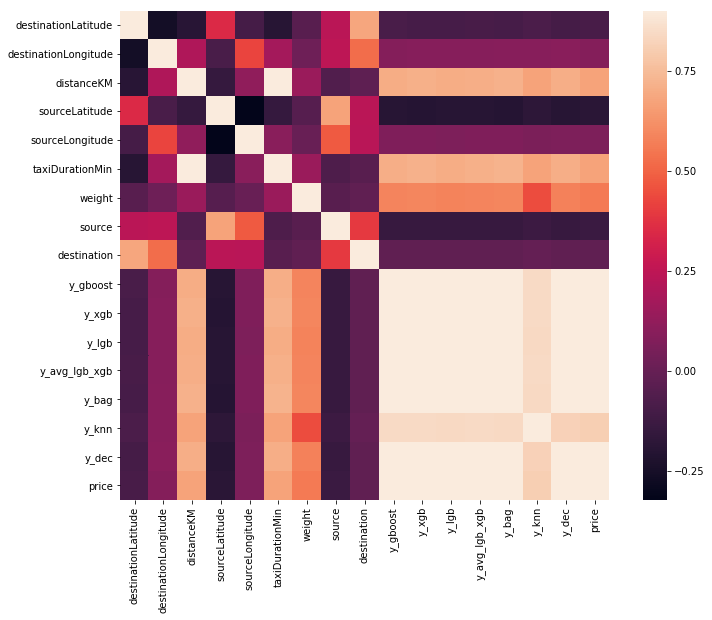

In [27]:
relevant_cols = ['destinationLatitude', 'destinationLongitude', 'distanceKM', 'sourceLatitude',
                 'sourceLongitude', 'taxiDurationMin', 'weight', 'source', 'destination', 
                 'y_gboost', 'y_xgb', 'y_lgb', 'y_avg_lgb_xgb', 'y_bag', 'y_knn', 'y_dec', 'price']

relevant_train = train[relevant_cols]

corrmat = relevant_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)